# Data Mining Lab 2
In this lab session we will focus on the use of Neural Word Embeddings 

## Table of Contents
1. Data preparation
2. Feature engineering
3. Model
4. Results evaluation
5. Other things you could try
6. Deep Learning
7. Word to Vector
8. Clustering
9. High-dimension Visualization



### Necessary Library Requirements:

#### Same as Lab1:
- [Jupyter](http://jupyter.org/) (Strongly recommended but not required)
    - Install via `pip3 install jupyter` and use `jupyter notebook` in terminal to run
- [Scikit Learn](http://scikit-learn.org/stable/index.html)
    - Install via `pip3 sklearn` from a terminal
- [Pandas](http://pandas.pydata.org/)
    - Install via `pip3 install pandas` from a terminal
- [Numpy](http://www.numpy.org/)
    - Install via `pip3 install numpy` from a terminal
- [Matplotlib](https://matplotlib.org/)
    - Install via `pip3 maplotlib` from a terminal
- [Plotly](https://plot.ly/)
    - Install via `pip3 install plotly` from a terminal
- [Seaborn](https://seaborn.pydata.org/)
    - Install and signup for `seaborn`
- [NLTK](http://www.nltk.org/)
    - Install via `pip3 install nltk` from a terminal

#### New Libraries to install:
- [Gensim](https://pypi.org/project/gensim/)
    - Install via `pip3 install gensim`

- [tensorflow](https://www.tensorflow.org/)
    - Install via `pip3 install tensorflow`
    - Also install `pip3 install tensorflow-hub`

- [Keras](https://keras.io/)
    - Install via `pip3 install keras`

---
## Introduction

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embedding and other deep information retrieval approaches.

![pic0](pics/pic0.png)

---
## 1. Data Preparation

Before beggining the lab, please make sure to download the [Google News Dataset](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) and place it in a folder named "GoogleNews" in the same directory as this file.

## 1.1 Load data

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd

### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [2]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [3]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [4]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [5]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


In [123]:
# Answer here
# Here, I follow the code of HW1, sorting and picking out the words with top30 frequencies and plot the graph.
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import plotly.express as px 

def top30word(df):
    count_vect = CountVectorizer()
    df_counts = count_vect.fit_transform(df.text)
    term_frequencies = np.asarray(df_counts.sum(axis=0))[0]
    mask = np.argsort(-term_frequencies)[:30]
    return count_vect.get_feature_names_out()[mask], term_frequencies[mask]

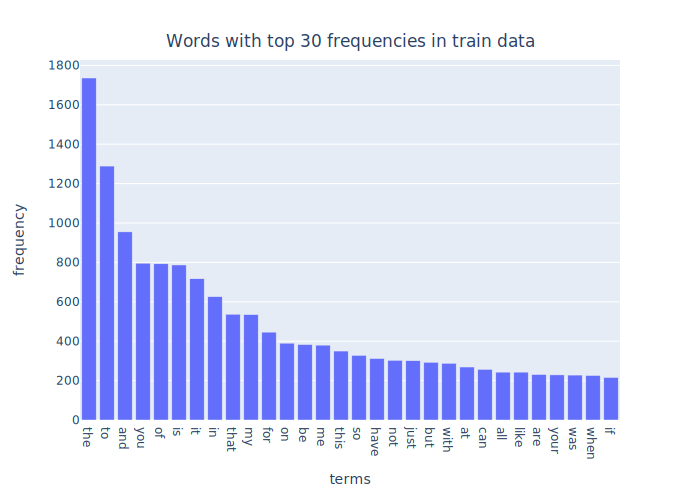

In [124]:
# result of training data.
x,y = top30word(train_df)
df_ = {"terms": x,
      "frequency": y}
fig = px.bar(df_, x = 'terms', y = 'frequency')
fig.update_layout(
    title={
        'text': "Words with top 30 frequencies in train data",
        'y':0.93,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show("svg")

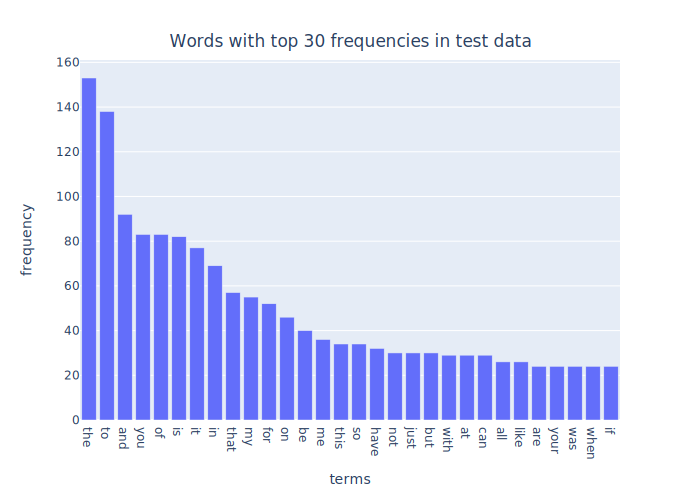

In [126]:
# result of testing data.
fx,y = top30word(test_df)
df_ = {"terms": x,
      "frequency": y}
fig = px.bar(df_, x = 'terms', y = 'frequency')
fig.update_layout(
    title={
        'text': "Words with top 30 frequencies in test data",
        'y':0.93,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show("svg")

---
### 1.2 Save data

We will save our data in Pickle format. The pickle module implements binary protocols for serializing and de-serializing a Python object structure.   
  
Some advantages for using pickle structure:  
* Because it stores the attribute type, it's more convenient for cross-platform use.  
* When your data is huge, it could use less space to store also consume less loading time.   

In [127]:
## save to pickle file
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

In [128]:
import pandas as pd

## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---
### 1.3 Exploratory data analysis (EDA)

Again, before getting our hands dirty, we need to explore a little bit and understand the data we're dealing with.

In [129]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger       857
fear       1147
joy         823
sadness     786
Name: text, dtype: int64

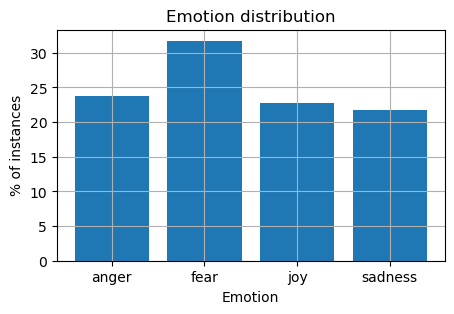

In [130]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

---

## 2. Feature engineering
### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [131]:
from sklearn.feature_extraction.text import CountVectorizer

In [132]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 

In [133]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

In [134]:
# check the result
train_data_BOW_features

<3613x10115 sparse matrix of type '<class 'numpy.int64'>'
	with 51467 stored elements in Compressed Sparse Row format>

In [135]:
type(train_data_BOW_features)

scipy.sparse._csr.csr_matrix

In [136]:
# add .toarray() to show
train_data_BOW_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [137]:
# check the dimension
train_data_BOW_features.shape

(3613, 10115)

In [138]:
# observe some feature names
feature_names = BOW_vectorizer.get_feature_names_out()
feature_names[100:110]

array(['2k17', '2much', '2nd', '30', '300', '301', '30am', '30pm', '30s',
       '31'], dtype=object)

The embedding is done. We can technically feed this into our model. However, depending on the embedding technique you use and your model, your accuracy might not be as high, because:

* curse of dimensionality  (we have 10,115 dimension now)
* some important features are ignored (for example, some models using emoticons yeld better performance than counterparts)

In [139]:
"😂" in feature_names

False

Let's try using another tokenizer below.

In [140]:
import nltk

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

## check dimension
train_data_BOW_features_500.shape

(3613, 500)

In [141]:
train_data_BOW_features_500.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 9, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [142]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()
feature_names_500[100:110]

array(['change', 'cheer', 'cheerful', 'cheerfully', 'cheering', 'cheery',
       'come', 'comes', 'could', 'country'], dtype=object)

In [143]:
"😂" in feature_names_500

True

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [144]:
# Answer here
# I use the TfidfVectorizer in sklearn and set the `max_fatures` to 1000, and show the names for features [100:110].

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_vectorizer.fit(train_df['text'])

feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names[100:110]

array(['bitter', 'black', 'blacks', 'blame', 'blessed', 'blood', 'bloody',
       'blues', 'body', 'boiling'], dtype=object)

---
## 3. Model
### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [146]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [147]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['fear', 'fear', 'joy', 'joy', 'anger', 'fear', 'joy', 'joy',
       'fear', 'anger'], dtype=object)

---
## 4. Results Evaluation

Now we will check the results of our model's performance

In [148]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))


training accuracy: 0.99
testing accuracy: 0.68


In [149]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.66      0.68      0.67        84
        fear       0.66      0.69      0.67       110
         joy       0.72      0.71      0.71        79
     sadness       0.70      0.64      0.67        74

    accuracy                           0.68       347
   macro avg       0.68      0.68      0.68       347
weighted avg       0.68      0.68      0.68       347



In [150]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[57 18  6  3]
 [16 76  9  9]
 [ 6  9 56  8]
 [ 7 13  7 47]]


In [151]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

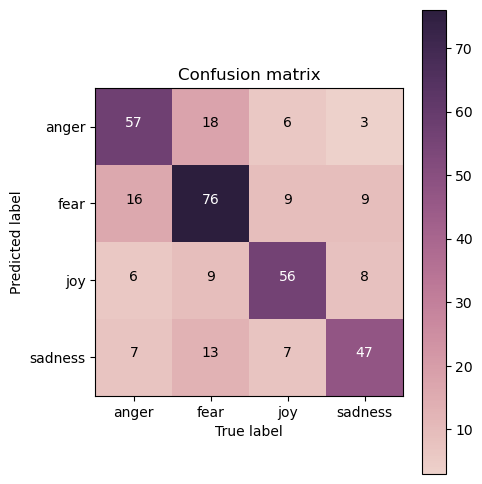

In [152]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

### Answer here
1. First, I would like to convince you that, the x and y labels are wrong in the confusion matrix graph, they are swapped. Which means that x label should be prediction label and y label should be the true label. Assume the labels that are shown in the above graph is correct, with the recall = TP / (TP + FN) that the denomination is the number of true values, so the denomination is computed by the column-wise sum. For example, in the class sadness: Recall = 47/(48+8+9+3) = 0.701, but this value is the precision value in the classification report. In another point of view, the denominator of precision is the row-wise sum: precision of sadness: 47/ (47+7+13+7) = 0.635 which is the recall value in the classification report. I hope this can convince you the x,y labels are swapped.
2. The precision value of joy class is the best among 4 classes, this is reasonable because this is the only class presenting `good` emotion while others are `bad`.
3. From the confusion matrix, we can see that the model is confused by the data of anger and fear. It is reasonable, because when people face dangerous, they will choose fight or escape. Therefore, I think in some case of anger and fear, they are presenting they meet something dangerous (or take some risks), the words they used are similar, but the reponse of people are quite different.
4. We can see that the training accuarcy is extremely high (0.99) but testing accuarcy is low (0.68) with very large difference (0.31). Overfitting occurs, this is common in the model of decision tree because the it is a greedy algorithm and split until pure case. We need pruning or booststrap method to avoid overfitting.


---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

training accuracy: 0.79
testing accuracy: 0.7
              precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.73      0.77      0.75       110
         joy       0.78      0.71      0.74        79
     sadness       0.64      0.62      0.63        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.70      0.70      0.70       347



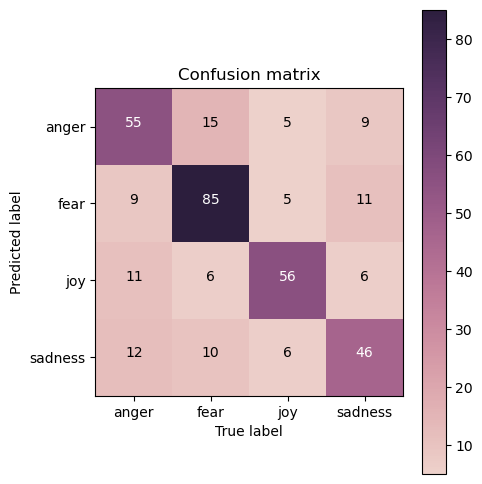

In [153]:
# Answer here
from sklearn.naive_bayes import MultinomialNB

clf_mnb = MultinomialNB()
clf_mnb.fit(X_train, y_train)
y_pred_mnb_train = clf_mnb_freq.predict(X_train)
y_pred_mnb_test = clf_mnb_freq.predict(X_test)

from sklearn.metrics import accuracy_score
mnb_acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_mnb_train)
mnb_acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_mnb_test)

print('training accuracy: {}'.format(round(mnb_acc_train, 2)))
print('testing accuracy: {}'.format(round(mnb_acc_test, 2)))

print(classification_report(y_true=y_test, y_pred=y_pred_mnb_test))

cm = confusion_matrix(y_true=y_test, y_pred=y_pred_mnb_test)
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

### Answer here

From the above results, the validation accuracy between two models are almost the same (DT: 0.69, NB: 0.7); the training accuracy of Naive Bayes classifier is lower than the training accuracy of Decision tree model. We only judge the overfitting is happened or not by the difference of training and testing accuaracy, so the overfitting of Naive Bayes model is not strong as the Decision Tree model.

Decision tree will split the data until the data become pure. Real data is dirty, especially in our case we have 500 features, the number of spliting will be propotional to the number of data. For each node, we need to estimate the threshold and feature, which is at least 2 parameters to describe, which means that for the decision tree model, the number of parameters is at least 2\*3613 = 7226. In the Naive bayes model, the number of parameter depends on the asspumtion of the conditional probabiltiy, which is multinomial distribution in our case. For the multinomial distribuition, one feature needs two parameters ($\mu$, $\sigma$) to describe (500 features in our case), and because we need conditional probabiltity for 4 class, the number of parameters is around 4\*2\*500 = 4000. Therefore, model complexity of naive bayes is less than the decision tree model, and cause less overfitting phenomenon.

---

## 5. Other things you can try

Thus, there are several things you can try that will affect your results. In order to yield better results, you can experiment by: 
- Trying different features (Feature engineering)e.g Word2Vec, PCA, LDA, FastText, Clustering
- Trying different models
- Analyzing your results and interpret them to improve your feature engineering/model building process
- Iterate through the steps above until finding a satisfying result

Remember that you should also consider the task at hand and the model you'll feed the data to. 

---
## 6. Deep Learning

We use [Keras](https://keras.io/) to be our deep learning framwork, and follow the [Model (functional API)](https://keras.io/models/model/) to build a Deep Neural Network (DNN) model. Keras runs with Tensorflow in the backend. It's a nice abstraction to start working with NN models. 

Because Deep Learning is a 1-semester course, we can't talk about each detail about it in the lab session. Here, we only provide a simple template about how to build & run a DL model successfully. You can follow this template to design your model.

We will begin by building a fully connected network, which looks like this:

![Fully Connected Network](pics/pic1.png)

(source: https://github.com/drewnoff/spark-notebook-ml-labs/tree/master/labs/DLFramework)


### 6.1 Prepare data (X, y)

In [154]:
import keras

# standardize name (X, y) 
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


### 6.2 Deal with categorical label (y)

Rather than put your label `train_df['emotion']` directly into a model, we have to process these categorical (or say nominal) label by ourselves. 

Here, we use the basic method [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our categorical  labels to numerical ones.


In [155]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 694       anger
2887    sadness
2669        joy
2215        joy
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


### 6.3 Build model

In [156]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


![Imgur](pics/pic2.png)

In [157]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_3 (Dense)             (None, 64)                32064     
                                                                 
 re_lu_2 (ReLU)              (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_3 (ReLU)              (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
 softmax_1 (Softmax)         (None, 4)                 0   

### 6.4 Train

In [158]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25
113/113 [==============================] - 0s 936us/step - loss: 1.3362 - accuracy: 0.3462 - val_loss: 1.2884 - val_accuracy: 0.4236
Epoch 2/25
113/113 [==============================] - 0s 525us/step - loss: 1.0063 - accuracy: 0.6366 - val_loss: 0.9139 - val_accuracy: 0.6772
Epoch 3/25
113/113 [==============================] - 0s 527us/step - loss: 0.5874 - accuracy: 0.7910 - val_loss: 0.7709 - val_accuracy: 0.7003
Epoch 4/25
113/113 [==============================] - 0s 531us/step - loss: 0.4057 - accuracy: 0.8519 - val_loss: 0.7648 - val_accuracy: 0.6916
Epoch 5/25
113/113 [==============================] - 0s 530us/step - loss: 0.3208 - accuracy: 0.8854 - val_loss: 0.7905 - val_accuracy: 0.6945
Epoch 6/25
113/113 [==============================] - 0s 526us/step - loss: 0.2582 - accuracy: 0.9112 - val_loss: 0.8647 - val_accuracy: 0.6801
Epoch 7/25
113/113 [==============================] - 0s 545us/step - loss: 0.2059 - accuracy: 0.9291 - val_loss: 0.8648 - val_accuracy:

### 6.5 Predict on testing data

In [159]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

3/3 [==============================] - 0s 1ms/step


array([[1.7511545e-03, 8.1743831e-03, 9.8954725e-01, 5.2719429e-04],
       [2.7584616e-07, 3.4328699e-04, 4.2942472e-09, 9.9965644e-01],
       [1.1879837e-06, 2.4561755e-06, 9.9999070e-01, 5.5878227e-06],
       [3.6039871e-01, 3.4925312e-01, 1.8392211e-01, 1.0642606e-01],
       [9.9939215e-01, 2.0440044e-04, 3.4103743e-06, 3.9999097e-04]],
      dtype=float32)

In [160]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['joy', 'sadness', 'joy', 'anger', 'anger'], dtype=object)

In [161]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.71


In [162]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.346250,1.336228,0.423631,1.288392
1,1,0.636590,1.006255,0.677233,0.913946
2,2,0.791032,0.587445,0.700288,0.770933
3,3,0.851924,0.405707,0.691643,0.764807
4,4,0.885414,0.320786,0.694524,0.790509
5,5,0.911154,0.258186,0.680115,0.864689
6,6,0.929145,0.205926,0.711816,0.864820
7,7,0.942430,0.176352,0.714697,0.898956
8,8,0.952948,0.153436,0.700288,0.983071
9,9,0.961528,0.125491,0.694524,1.029522


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="pics/pic3.png" style="width: 300px;"/> </td>
    <td><img src="pics/pic4.png" style="width: 300px;"/> </td>
</tr></table>

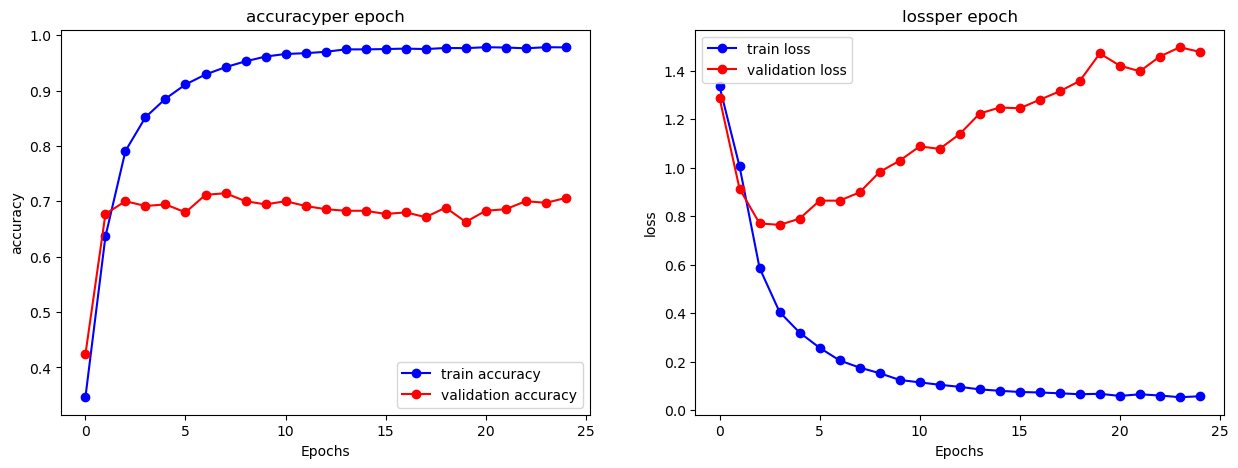

In [165]:
# Answer here
fig = plt.figure(figsize = (15,5))
for p, m in zip(range(2), ['accuracy', 'loss']):
    ax = fig.add_subplot(1, 2, p+1)
    x = training_log['epoch']
    y1 = training_log[m]
    y2 = training_log[f'val_{m}']
    ax.plot(x, y1, 'o-', label=f'train {m}', color = 'b')
    ax.plot(x, y2, 'o-', label=f'validation {m}', color = 'r')
    ax.legend()
    ax.set_title(m + "per epoch")
    ax.set_xlabel('Epochs')
    ax.set_ylabel(m)
plt.show()

### interpretation.

We can observe that, the training accuarcy and loss are already converge; the validation accuracy is converge also, but it appears a huge difference from the training accuracy. On the other hand, the validation loss is much greater than the training loss. In conclustion, overfitting occurs.

Besides, validation loss is still increase, but validation accuracy is converge already. It is because model becomes assertive, i.e. the constrast between prediction values tends to be large. In the calculation of accuarcy, it only depends on the prediction result (right/wrong), but for the loss, it depends on the values of prediction probability. When the model becomes more and more assertive, it will not affect the accuracy because it is wrong already, but the probability is worse than before. This is also a phenomenon of overfitting. 

The overfitting occurs when number of epoch greater than 4. I think there are too many parameters in the model, only 3000+ data but with 30000+ parameters, the model is likely to memeorize most the training data (training accuaracy ~ 0.98) which leads to overfitting.

---

### Note

If you don't have a GPU (level is higher than GTX 1060) or you are not good at setting lots of things about computer, we recommend you to use the [kaggle kernel](https://www.kaggle.com/kernels) to do deep learning model training. They have already installed all the librarys and provided free GPU for you to use.

Note however that you will only be able to run a kernel for 6 hours. After 6 hours of inactivity, your Kaggle kernel will shut down (meaning if your model takes more than 6 hours to train, you can't train it at once).


### More Information for your reference

* Keras document: https://keras.io/
* Keras GitHub example: https://github.com/keras-team/keras/tree/master/examples
* CS229: Machine Learning: http://cs229.stanford.edu/syllabus.html
* Deep Learning cheatsheet: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning
* If you want to try TensorFlow or PyTorch: https://pytorch.org/tutorials/
https://www.tensorflow.org/tutorials/quickstart/beginner

---
## 7. Word2Vector

We will introduce how to use `gensim` to train your word2vec model and how to load a pre-trained model.

https://radimrehurek.com/gensim/index.html

### 7.1 Prepare training corpus

In [166]:
## check library
import gensim

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
694,10694,Asian Tiger #Mosquitoes are so relentless. Mor...,"[Asian, Tiger, #, Mosquitoes, are, so, relentl..."
2887,40060,My soul is weary of fighting the battles in th...,"[My, soul, is, weary, of, fighting, the, battl..."
2669,30665,@johnwintertweet dudes who wanna play some bas...,"[@, johnwintertweet, dudes, who, wan, na, play..."
2215,30211,@chrisrock brings back great memories of hilar...,"[@, chrisrock, brings, back, great, memories, ..."
2009,30005,"Today I reached 1000 subscribers on YT!! , #go...","[Today, I, reached, 1000, subscribers, on, YT,..."


In [167]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['Asian', 'Tiger', '#', 'Mosquitoes', 'are', 'so', 'relentless', '.', 'More', 'aggressive', 'than', 'the', 'kind', 'I', 'dealt', 'w/as', 'a', 'kid', '.']),
       list(['My', 'soul', 'is', 'weary', 'of', 'fighting', 'the', 'battles', 'in', 'this', 'world', '.', '#', 'BlackInAmerica', '#', 'WeAreNotSafe']),
       list(['@', 'johnwintertweet', 'dudes', 'who', 'wan', 'na', 'play', 'some', 'bass', 'but', 'not', 'buy', 'a', 'bass', '(', 'me', ')', 'rejoice'])],
      dtype=object)

### 7.2 Training our model

You can try to train your own model. More details: https://radimrehurek.com/gensim/models/word2vec.html

In [168]:
from gensim.models import Word2Vec

## setting
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_epochs)

![Imgur](https://i.imgur.com/Fca3MCs.png)

### 7.3 Generating word vector (embeddings)

In [169]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

array([ 0.30486745,  0.4664646 , -0.41219413,  0.09662538, -0.22854449,
       -1.4699999 ,  0.5939052 ,  1.896857  , -0.58596045, -0.41223007,
       -0.6907195 , -0.7643697 , -0.07615973,  0.37725392,  0.00641367,
       -0.17871717,  0.5156964 ,  0.02018997,  0.56106716, -0.967726  ,
        0.8715753 ,  0.8093855 ,  0.6885046 , -0.07467763, -0.0515068 ,
       -0.09017012, -0.28884113,  0.745367  , -0.6176538 , -0.09042463,
       -0.05161294, -0.14047953,  0.46776778, -0.3861274 , -0.17333673,
        0.5366398 ,  0.44373393, -0.1707942 , -0.16751975, -0.65146714,
        0.12355691,  0.06715024, -0.6233588 ,  0.5183342 ,  0.61915773,
       -0.5858351 , -0.8421583 , -0.01883674, -0.07253143,  0.21093258,
       -0.18313676, -0.12844884, -0.41570675, -0.04510992, -0.40362656,
       -0.61474496, -0.08751189, -0.523507  , -0.26280695, -0.3974652 ,
        0.2605696 ,  0.04871584,  0.2134868 ,  0.05717367, -0.59973097,
        1.1106201 ,  0.14165996,  0.45950797, -1.3969773 ,  0.89

In [170]:
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

[('help', 0.9198861122131348),
 ('Be', 0.9179573655128479),
 ('plz', 0.9090338349342346),
 ("'you", 0.8967644572257996),
 ('bday', 0.8967186212539673),
 ('birthday', 0.8904588222503662),
 ('cry', 0.888047993183136),
 ('muchlove', 0.88770592212677),
 ('🕋', 0.8876410126686096),
 ('establishment', 0.886172890663147)]

### 7.4 Using a pre-trained w2v model

Instead of training your own model ,you can use a model that has already been trained. Here, we see 2 ways of doing that:


#### (1) Download model by yourself

source: [GoogleNews-vectors-negative300](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?resourcekey=0-wjGZdNAUop6WykTtMip30g)

more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [171]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = "GoogleNews-vectors-negative300.bin"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

#### (2) Using gensim api

Other pretrained models are available here: https://github.com/RaRe-Technologies/gensim-data

In [172]:
import gensim.downloader as api

## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

load ok


[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.9336148500442505),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678),
 ('hello', 0.9158350825309753),
 ('thanks', 0.9150084853172302),
 ('merry', 0.9053248763084412),
 ('bless', 0.902732253074646),
 ('wish', 0.9013165235519409)]

### 7.5 king + woman - man = ?

Let's run one of the most famous examples for Word2Vec and compute the similarity between these 3 words:

In [86]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411403656006)]

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


#### Answer here

a. Use a sentence vector to represent the sentence.
1. Direct summation of the word vectors: Because we have all the word vectors, then we can add up the words which are contained in sentence. For example: "I have a dog" --> word_vector("I") + word_vector("have") + word_vector("a") + word_vector("dog") --> sentence vector. However, this is generated by a strong assumption that every word contributes equally in the sentence, but of course we know that it is not true.
3. Weighted summation of word vectors: To solve the drawback of point1 we have mentioned, we can extend the idea of point1 by TFIDF concept. Then the contribution of different words are computed, which will caused the simply summation of word vectors become weighted summation. We can model that when the word get higher TFIDF value, then the coeffient in front of that word will become higher; if TFIDF value is lower, then coeifficient is lower. Note that with the normalization of coefficient $\sum_{i} c_{i} = 1$.

Once we have the sentence vector, then it is the same as the data with multiple features and attempt to predict value, we can choose the models we familiar with.

b. Concat word vectors become a matrix, and use model to solve the problem.
1. It is worth noting that an obvious drawback of point(a) is it ignore the order of word that appear in the sentence, it is also an important information that we care. We can use sequential model to capture the information between words with the consideration of order. For example: RNN model. With time evolution, we input the words vector sequentially, and each time step RNN unit outputs the memory it learns, which has considered the memories of previous time steps. We can use the output of final time step to predict.

### 8. Clustering: k-means

Here we introduce how to use `sklearn` to do the basic **unsupervised learning** approach, k-means.    

more details: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


#### Basic concept

![Image](https://i.imgur.com/PEdUf54.png)

(img source: https://towardsdatascience.com/k-means-clustering-identifying-f-r-i-e-n-d-s-in-the-world-of-strangers-695537505d)

In [87]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]

target words:  ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']


In [88]:
from sklearn.cluster import KMeans

# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_

# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

word: happy 	 cluster: 0
word: fear 	 cluster: 0
word: angry 	 cluster: 0
word: car 	 cluster: 1
word: teacher 	 cluster: 1
word: computer 	 cluster: 1


![Imgur](pics/pic6.png)

In [92]:
#check cluster membership
word = 'student'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([1], dtype=int32)

In [93]:
#check cluster membership
word = 'sad'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([0], dtype=int32)


## 9. High-dimension Visualization: t-SNE

No matter if you use the Bag-of-words, TF-IDF, or Word2Vec, it's very hard to see the embedding result, because the dimension is larger than 3.  

In Lab 1, we already talked about PCA. We can use PCA to reduce the dimension of our data, then visualize it. However, if you dig deeper into the result, you'd find it is insufficient.

Our aim will be to create a visualization similar to the one below:

![Image](pics/pic7.png)
source: https://www.fabian-keller.de/research/high-dimensional-data-visualization 

Here we would like to introduce another visualization method called t-SNE.  
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html 

### 9.1 Prepare visualizing target

Let's prepare data lists like:
- happy words
- angry words
- data words
- mining words

In [91]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


### 9.2 Plot using t-SNE (2-dimension)

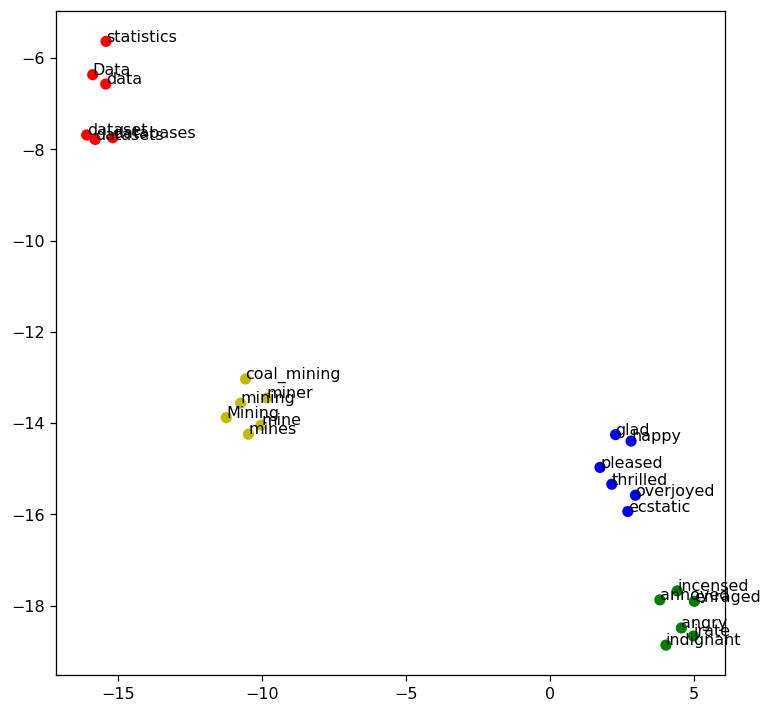

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [117]:
# Answer here
# Here, I simply change the parameter `topn` to 15, and `word_list` become ['happy', 'angry', 'sad', 'fear'].
# with constructing `sad_words` and `fear_words` instead of `data_words` and `mining_words`

word_list = ['happy', 'angry', 'sad', 'fear']

topn = 15
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
sad_words = ['sad'] + [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]        
fear_words = ['fear'] + [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]        

target_words = happy_words + angry_words + sad_words + fear_words
print('\ntarget words: ')
print(target_words)

cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn


target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry', 'sad', 'saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet', 'fear', 'fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']

color list:


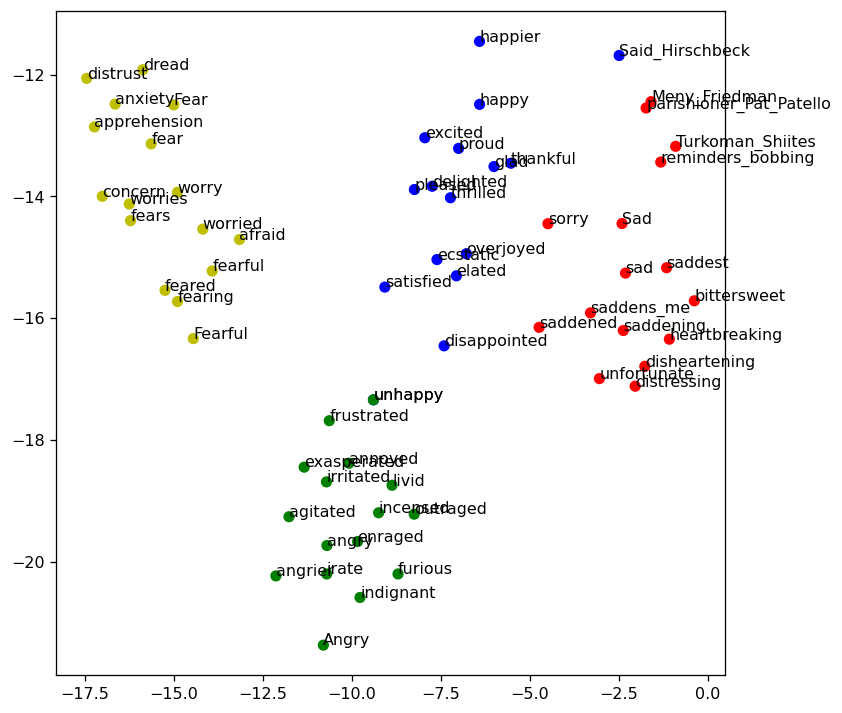

In [116]:
# Here, follow the code of 9.2 and plot the 2D graph.
## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---